# Find SNP proxies in R

2018-04-29

Kamil Slowikowski

## Summary

We use R to find the proxies for one SNP in the public 1000 Genomes data.

We'll take advantage of the public imputed genotypes hosted on a server at the
University of Washington.

This notebook is intentionally brief. For more details, check out the vignettes and
reference manuals for these packages:

- [snpStats]
- [VariantAnnotation]
- [Rsamtools]

[snpStats]: https://www.bioconductor.org/packages/release/bioc/html/snpStats.html
[VariantAnnotation]: https://www.bioconductor.org/packages/release/bioc/html/VariantAnnotation.html
[Rsamtools]: https://www.bioconductor.org/packages/release/bioc/html/Rsamtools.html

## Install and load packages

In [1]:
source("http://bioconductor.org/biocLite.R")
packages <- c("Rsamtools", "VariantAnnotation", "snpStats")

for (p in packages) {
  if (!suppressMessages(require(p, character.only = TRUE, quietly = TRUE))) {
    biocLite(p, suppressUpdates = TRUE, ask = FALSE)
  }
}

Bioconductor version 3.7 (BiocInstaller 1.29.6), ?biocLite for help


In [2]:
if (!require("pacman")) { install.packages("pacman") }
pacman::p_load(
  ggplot2,
  glue,
  Rsamtools,
  snpStats,
  VariantAnnotation
)

Loading required package: pacman


## Read a VCF file

The VCF file can be located on a public HTTP server or on your local disk.

The VCF should be compressed with **bgzip** (not with gzip) and accompanied by
a **tabix** index file `filename.vcf.gz.tbi` to locate chunks of data quickly.

In [3]:
region <- list(
  genome = "hg19",
  chrom  = "12",
  start  = 483090,
  end    = 683090
)

# A local file on your disk.
# vcf_file <- glue("chr{chrom}.1kg.phase3.v5a.vcf.gz", chrom = region$chrom)

# A remote file on an HTTP server.
vcf_file <- glue(file.path(
  "http://bochet.gcc.biostat.washington.edu",
  "beagle/1000_Genomes_phase3_v5a/vcf.b37",
  "chr{chrom}.1kg.phase3.v5a.vcf.gz"
), chrom = region$chrom)

# Set parameters to retrieve one chunk of data.
param <- ScanVcfParam(
  which = GRanges(
    seqnames = region$chrom, 
    ranges = IRanges(region$start, region$end)
  )
)

# Get VCF data from a local file or remote URL.
vcf <- readVcf(file = TabixFile(vcf_file), genome = region$genome, param = param)
gt <- genotypeToSnpMatrix(vcf)

# Glance at the upper left corner of the genotype matrix.
gt$genotypes[1:5,1:5]

Warning message in .local(x, ...):
“variants with >1 ALT allele are set to NA”non-single nucleotide variations are set to NA


,rs6489463,rs192120541,rs547723211,rs569164619,rs150886436
HG00096,01,01,00,01,01
HG00097,03,01,00,01,01
HG00099,03,01,00,01,01
HG00100,02,01,00,01,01
HG00101,02,01,00,01,01


## Get r squared values for a specific SNP

Let's define a convenience function that makes a dataframe with $D'$ and $r^2$ values
for each SNP in the region with our chosen SNP.

In [4]:
get_snp_proxies <- function(this_snp, vcf, gt) {
  # Ensure the SNP is present.
  stopifnot(this_snp %in% colnames(gt$genotypes))
  # Compute linkage disequilibrium statistics.
  gt_ld <- ld(
    x = gt$genotypes,
    y = gt$genotypes[,this_snp,drop=FALSE],
    stats = c("D.prime", "R.squared")
  )
  # Bind the stats into a dataframe.
  cols <- names(gt_ld)
  gt_ld <- do.call(cbind, gt_ld)
  colnames(gt_ld) <- cols
  # Get the position, width, strand, ..., for each SNP
  gt_meta <- rowRanges(vcf)
  # Bind the metadata to the LD statistics.
  stopifnot(all(names(gt_meta) == rownames(gt_ld)))
  gt_ld <- cbind(as.data.frame(gt_meta), gt_ld)
  return(gt_ld)
}

You can run `?snpStats::ld` to learn more about the statistics
implemented in the `snpStats` package.

In [5]:
this_snp <- "rs11063140"
this_ld <- get_snp_proxies(this_snp, vcf, gt)

head(this_ld)

,seqnames,start,end,width,strand,paramRangeID,REF,ALT,QUAL,FILTER,D.prime,R.squared
rs6489463,12,483130,483130,1,*,NA,G,T,NA,PASS,0.01531193,2.271030e-05
rs192120541,12,483173,483173,1,*,NA,G,A,NA,PASS,1.00000000,6.329190e-05
rs547723211,12,483350,483350,1,*,NA,T,TA,NA,PASS,NA,NA
rs569164619,12,483416,483416,1,*,NA,G,T,NA,PASS,1.00000000,8.442296e-05
rs150886436,12,483479,483479,1,*,NA,T,C,NA,PASS,0.25794641,1.503325e-02
rs376349655,12,483768,483768,1,*,NA,T,C,NA,PASS,1.00000000,5.273271e-05


## Plot the r squared values in a region

Warning message:
“Removed 291 rows containing missing values (geom_point).”

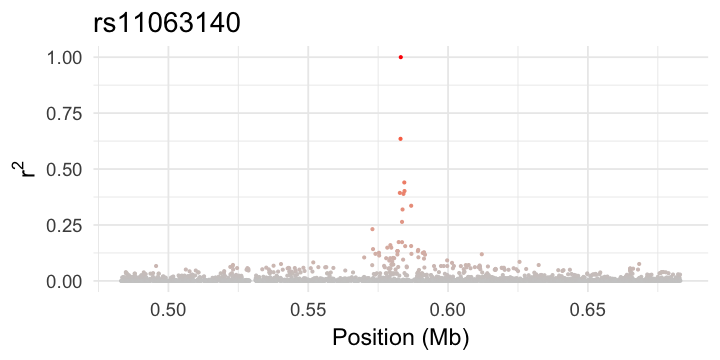

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggplot(this_ld, aes(x = end / 1e6, y = R.squared, color = R.squared)) +
geom_point(size = 0.5) +
scale_color_gradient2(mid = "grey80", high = "red") +
theme_minimal(base_size = 14) +
theme(legend.position = "none") +
labs(x = "Position (Mb)", y = bquote("r"^2), title = this_snp)